In [1]:
import gdal

import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [27]:
gtiff = gdal.Open("/Users/lmoresi/+Codes/Python/quagmire/Notebooks/data/ETOPO1_Ice_c_geotiff.tif")

width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T

img = np.fliplr(img)

imgLR = img[::10,::10]

In [29]:
dlons = np.mod(np.degrees(gridR.lons)+180.0, 360.0)
dlats = np.mod(np.degrees(gridR.lats)+90, 180.0)

ilons = img.shape[0] * dlons / 360.0
ilats = img.shape[1] * dlats / 180.0

icoords = np.stack((ilons, ilats))

from scipy import ndimage

meshheights = ndimage.map_coordinates(img, icoords , order=3, mode='nearest').astype(np.float)

In [30]:
# datafile = "/Users/lmoresi/Dropbox/+Research/Publications/MyPapers/CooperMiller-ContinentalStructure/Data/te_dat.xyte.txt"

datafile = "../Moho/repicked_Moho_table.txt"
moho_data = np.genfromtxt(datafile, delimiter=" ", comments=None, skip_header=1, missing_values=0.0, filling_values=0.0, invalid_raise=False)

In [98]:
la = moho_data[:,1]
lo = moho_data[:,0]
mo = moho_data[:,2] 

valid = np.where(data > 0.0)

lons = lo[valid]+np.random.random(lo[valid].shape)*.0001
lats = la[valid]+np.random.random(lo[valid].shape)*.0001
moho = mo[valid]

data_xyz = np.array( stripy.spherical.lonlat2xyz(np.radians(lons), np.radians(lats))).T

mean_moho = moho.mean()

In [116]:
grid0 = stripy.icosahedral_mesh(include_face_points=True, refinement_levels=0)
grid3 = stripy.icosahedral_mesh(include_face_points=True, refinement_levels=3)
gridR = stripy.icosahedral_mesh(include_face_points=True, refinement_levels=9)


triangulations = [grid1]
nearest, distances = triangulations[-1].nearest_vertex(lons, lats)

max_depth = 15

while nearest[0] == nearest[1] and max_depth > 0:

    lons, lats = triangulations[-1].centroid_refine_triangulation_by_vertices(vertices=nearest[0])
    new_triangulation = stripy.sTriangulation(lons, lats)
    nearest, distances = new_triangulation.nearest_vertex(points[:,0], points[:,1])
    triangulations.append(new_triangulation)
    
    max_depth -= 1

print "refinement_steps =", len(triangulations)

centroid_triangulations = triangulations[:]

print grid0.npoints, grid3.npoints, gridR.npoints

refinement_steps = 1
32 642 655362


In [99]:
## add extra points outside the data to complete the sphere

la_anti = -lats.mean()
lo_anti = -lons.mean()
mean_moho = moho.mean()





In [105]:
## Naive meshing of the data points

datagrid = stripy.sTriangulation(np.radians(lons), np.radians(lats))
cube_grid = stripy.spherical_meshes.triangulated_cube_mesh(refinement_levels=0)
cube_moho = np.random.random(cube_grid.npoints)*0.001 + mean_moho

lons_plus = np.hstack((lons, np.degrees(cube_grid.lons)))
lats_plus = np.hstack((lats, np.degrees(cube_grid.lats)))

moho_plus = np.hstack((moho, cube_moho))

datagrid_plus_pts = datagrid.join(cube_grid)
datagrid_plus = stripy.sTriangulation(np.radians(lons_plus), np.radians(lats_plus))




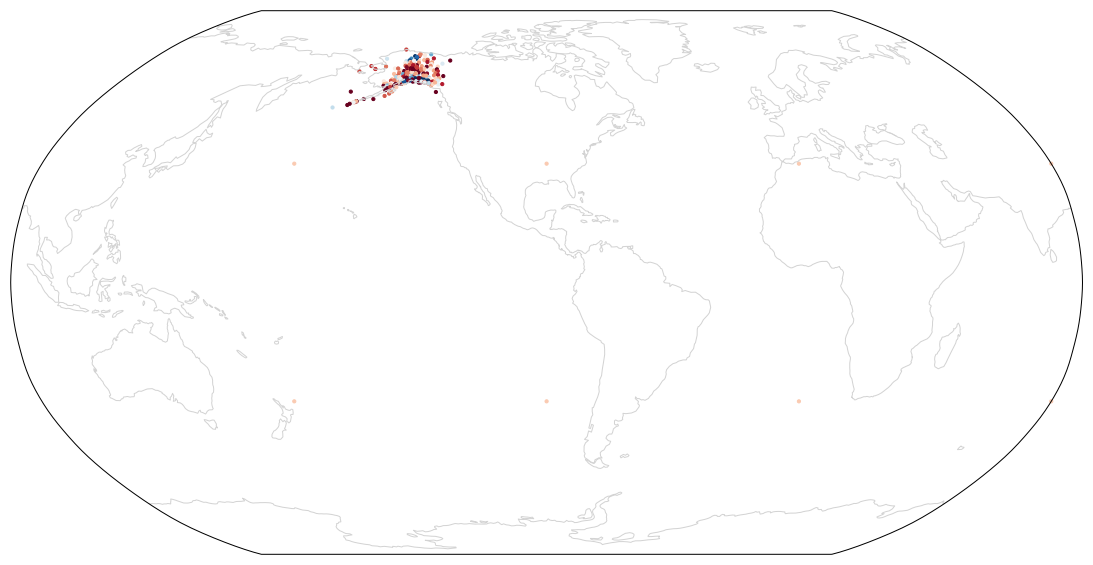

In [106]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Robinson(central_longitude=-90.0, globe=None))
ax.coastlines(color="lightgrey")
ax.set_global()

ax.scatter(lons_plus, lats_plus, c=moho_plus, cmap=plt.cm.RdBu, vmin=30.0, vmax=50.0,
            marker="o", s=10.0, transform=ccrs.Geodetic())

fig.show()

In [107]:
from LavaVu import lavavu

striangulationR = gridR
striangulation0 = grid3

wireframeI = striangulationR
trianglesI = striangulationR



lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[2000,1000], near=-10.0)

# Core 

tris = lv.triangles("InnerSphere",  wireframe=False, colour="#999999", opacity=1.0)
tris.vertices(striangulation0.points * 0.95 )
tris.indices(striangulation0.simplices)

tris3 = lv.triangles("datagrid",  wireframe=False, colour="#77ff88", opacity=1.0)
tris3.vertices(datagrid_plus.points)
tris3.indices(datagrid_plus.simplices)
tris3.values(moho_plus)
tris3.colourmap(["#555599","#995555"])
                
                
tris2 = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=0.5)
tris2.vertices(trianglesI.points * (1.0+0.000003*meshheights.reshape(-1,1)))
tris2.indices(trianglesI.simplices)
tris2.values(meshheights*0.001)
tris2.colourmap(["(-5.0)#555555", "(-0.001)#FFFFFF", "(0.0)#779977", "(0.1)#99AA99", "(1.0)#BBDDBB", "(5.0)#EEFFEE"] , logscale=False, range=[-7.0,5.0])   # Apply a built in colourmap

nodes = lv.points("DataPoints", pointsize=5.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(data_xyz*1.01)
nodes.values(moho)
nodes.colourmap(["Blue","Red"])

lv.window()

tris.control.Checkbox(property='wireframe', label="Core - wireframe")
tris2.control.Checkbox(property='wireframe', label="Surface - wireframe")
tris3.control.Checkbox(property='wireframe', label="Data - wireframe")


# tris2.control.show()

lv.control.Range('specular', range=(0,1), step=0.1, value=0)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [114]:
fine_grid = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, refinement_levels=8)

In [115]:
datagrid_plus.interpolate(fine_grid.lons, fine_grid.lats, moho_plus, order=3)


array([-57.13833452,  36.08113913,  37.65005205, ...,  37.33231324,
        37.33210426,  37.33238689])

In [109]:

weights = np.ones_like(moho_plus)
weights[moho.shape[0]::] = 0.1

smooth_d, deriv = datagrid_plus.smoothing(moho_plus, weights, 300.0, 0.5, 0.01)


ValueError: ierr=-3 in gradg
duplicate nodes were encountered.

In [48]:
def weighted_average_to_nodes(lons, lats, data, interpolator ):

    grid   = np.zeros(interpolator.npoints)
    norm   = np.zeros(interpolator.npoints)
    count  = np.zeros(interpolator.npoints, dtype=np.int)

    bcc, nodes = interpolator.containing_simplex_and_bcc(lons, lats)

    # Beware vectorising the reduction operation !!

    for i in range(0, len(data)):

        grid[nodes[i][0]] += bcc[i][0] * data[i]
        grid[nodes[i][1]] += bcc[i][1] * data[i]
        grid[nodes[i][2]] += bcc[i][2] * data[i]

        norm[nodes[i][0]] += bcc[i][0]
        norm[nodes[i][1]] += bcc[i][1]
        norm[nodes[i][2]] += bcc[i][2]
        
        count[nodes[i][0]] += 1
        count[nodes[i][1]] += 1
        count[nodes[i][2]] += 1
        

    grid[np.where(norm > 0.0)] /= norm[np.where(norm > 0.0)]
    
    return grid, norm, count



In [129]:

ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), data, grids[-1])

node_area = np.zeros(grids[-1].npoints)
t_areas = grids[-1].areas()

for t,simplex in enumerate(grids[-1].simplices):
    node_area[simplex] += t_areas[t] 

node_area /= node_area.max()


node_area.min()

vertices = np.where(np.logical_and(norm > 10.0, node_area > 0.001))[0]

print node_area.shape
print norm.shape
np.where(np.logical_and(norm > 10.0, node_area > 0.0001))[0]

(16792,)
(16792,)


array([ 4107,  4757,  4855,  5149,  7489,  7629,  9114,  9205, 10257,
       10474, 10539, 10621, 10660, 10692, 10859, 10928, 11005, 11165,
       11283, 11306, 11313, 11608, 11633, 11721, 11741, 11768, 11951,
       11992, 12276, 12533, 12552, 12625, 12683, 12745, 12787, 13083,
       13449, 13583, 13817, 13821, 13929, 13955, 13956, 13976, 13992,
       13997, 14019, 14066, 14081, 14094, 14097, 14111, 14120, 14126,
       14211, 14230, 14234, 14255, 14282, 14296, 14311, 14323, 14329,
       14349, 14352, 14367, 14415, 14436, 14451, 14462, 14484, 14493,
       14512, 14582, 14596, 14612, 14705, 14716, 14738, 14750, 14762,
       14795, 14823, 14824, 14847, 14870, 14886, 14944, 14957, 14972,
       15011, 15043, 15055, 15093, 15103, 15104, 15112, 15118, 15161,
       15167, 15178, 15184, 15205, 15213, 15263, 15292, 15303, 15324,
       15393, 15416, 15417, 15473, 15480, 15506, 15533, 15540, 15559,
       15587, 15616, 15707, 15715, 15760, 15764, 15765, 15768, 15793,
       15800, 15802,

In [132]:
grids = [grid0]

for i in range(0, 20):

    ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), data, grids[-1])
    
    node_area = np.zeros(grids[-1].npoints)
    t_areas = grids[-1].areas()

    for t,simplex in enumerate(grids[-1].simplices):
        node_area[simplex] += t_areas[t] 
  
    node_area /= node_area.max()
    
    vertices = np.where(np.logical_and(norm > 10.0, node_area > 0.001))[0]

    print vertices.shape[0], norm.min(), norm.max(), count.min(), count.max(), node_area.min()
    
    if vertices.shape[0] == 0:
        break

    newlons, newlats = grids[-1].edge_refine_triangulation_by_vertices(vertices=vertices)
    rgrid = stripy.sTriangulation(newlons, newlats)
    print newlons.shape[0], rgrid.npoints
    grids.append(rgrid)


ave_data, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), data, grids[-1])

## limit the minimum area


6 1040.7452348 8685.80209788 4894 22830 1.0
18 18
18 59.7323877667 4913.03243475 192 11141 0.55214965606
66 66
65 9.39552284205 2230.97355025 38 5886 0.465236709045
258 258
210 0.0 1525.40676048 0 3675 0.358633266584
973 973
419 0.0 972.086088515 0 2357 0.0972460923035
2975 2975
549 0.0 429.091007824 0 989 0.0242822741693
6127 6127
604 0.0 289.567553802 0 686 0.00606874075168
10081 10081
533 0.0 201.937198771 0 499 0.00151707095527
13954 13954
92 0.0 91.5489568617 0 177 0.000379260599345
14723 14723
0 0.0 91.5489568617 0 177 0.000201028987007


In [50]:
tgrids = [grid0]

for i in range(0, 20):
    triangles = tgrids[-1].containing_triangle(np.radians(lons),np.radians(lats))
    tcount = np.bincount(triangles)
    t2refine = np.where(tcount > 10)[0]

    print t2refine.shape[0], tcount.min(), tcount.max()
    
    if t2refine.shape == 0:
        break

    newlons, newlats = tgrids[-1].centroid_refine_triangulation_by_triangles(triangles=t2refine)
    rgrid = stripy.sTriangulation(newlons, newlats)
    tgrids.append(rgrid)


t_ave_data, t_norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), data, tgrids[-1])

8 412 7544
24 63 3947
69 5 3785
178 0 1999
318 0 1595
424 0 731
545 0 691
588 0 322
548 0 238
461 0 138
350 0 101
241 0 75
137 0 67
96 0 58
67 0 47
55 0 47
41 0 47
28 0 53
25 0 47
17 0 47


In [143]:
# Nodes where norm == 0 need to be interpolated ... 

zero_points = np.where(norm == 0.0)

lons = grids[-1].lons[zero_points]
lats = grids[-1].lats[zero_points]


fixed_points = datagrid.interpolate(lons, lats, data,order=1)

ave_data[zero_points] = fixed_points

In [147]:
from LavaVu import lavavu

striangulationR = grids[-1]
striangulation0 = grids[2]

wireframeI = striangulationR
trianglesI = gridR

refined_data = ave_data

opacity = t_norm / t_norm.max()

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[2000,1000], near=-10.0)

# Core 

tris = lv.triangles("LAB",  wireframe=False, colour="#999999", opacity=1.0)
tris.vertices(striangulation0.points * 0.95 )
tris.indices(striangulation0.simplices)

tris3 = lv.triangles("datagrid",  wireframe=True, colour="#77ff88", opacity=1.0)
tris3.vertices(striangulationR.points)
tris3.indices(striangulationR.simplices)
tris3.values(ave_data, label="data")
tris3.colourmap(["#555599","#995555"])



tris2 = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=0.5)
tris2.vertices(trianglesI.points * (1.0+0.000003*meshheights.reshape(-1,1)))
tris2.indices(trianglesI.simplices)
tris2.values(meshheights*0.001)
tris2.colourmap(["(-5.0)#555555", "(-0.001)#FFFFFF", "(0.0)#779977", "(0.1)#99AA99", "(1.0)#BBDDBB", "(5.0)#EEFFEE"] , logscale=False, range=[-7.0,5.0])   # Apply a built in colourmap

nodes = lv.points("DataPoints", pointsize=1.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(data_xyz*1.001)
nodes.values(data)
nodes.colourmap(["Blue","Red"])

lv.window()

tris.control.Checkbox(property='wireframe', label="Core - wireframe")
tris2.control.Checkbox(property='wireframe', label="Surface - wireframe")
tris3.control.Checkbox(property='wireframe', label="Data - wireframe")


# tris2.control.show()

lv.control.Range('specular', range=(0,1), step=0.1, value=0)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
lv.control.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [145]:
striangulationR = grids[-1]
refined_data = ave_data
weights = 0.01 + norm / norm.max()

smooth_d, deriv = striangulationR.smoothing(refined_data, weights, 10.0, 0.5, 0.01)



In [76]:
norm.shape, grids[-1].npoints

((20278,), 20278)

In [16]:
99=1

SyntaxError: can't assign to literal (<ipython-input-16-b935cfd45228>, line 1)

In [ ]:
## Define a base mesh that we will refine later

mesh = stripy.icosahedral_mesh(refinement_levels=1, include_face_points=True)

print "Size of mesh - 1 ", mesh.npoints

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.colors as colors

global_extent     = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=30, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()


In [ ]:
# valid_map = np.isnan(te_data)
# valid_point = np.empty(te_data.shape[0])

# for i in range(0,len(valid_point)):
#     valid_point[i] = np.logical_not(np.any( valid_map[i,:] ))
     
# print np.count_nonzero(valid_point), " points are valid"

# lons = te_data[np.where(valid_point),0].reshape(-1)
# lats = te_data[np.where(valid_point),1].reshape(-1)
# te   = te_data[np.where(valid_point),2].reshape(-1)


In [ ]:
## Background image

globaletopo = gdal.Open("/Users/lmoresi/+Codes/Python/quagmire/Notebooks/data/ETOPO1_Ice_c_geotiff.tif")


# globaletopo_img   = globaletopo.ReadAsArray()[::30,::30]
# del globaletopo

# from matplotlib.colors import LightSource, Normalize

# cmap=plt.cm.Greys
# ls = LightSource(315, 45)
# hillshade = ls.shade(globaletopo_img, cmap, vert_exag=0.00025)[1::,1::]

## Drop one point here because the data are 361 x 721 !!

In [ ]:
fig = plt.figure(figsize=(24,12), facecolor="none")
ax  = plt.subplot(111, projection=projection3)
ax.coastlines()
ax.set_extent([-140.0,-70.0,20.0,80.0])
ax.set_global()

ax.imshow(hillshade, origin='upper', transform=base_projection, extent=global_extent, zorder=0)


colormap = plt.cm.get_cmap('Spectral', 11)
norm = colors.Normalize(vmin=0, vmax=200, clip=True)

m = ax.scatter(lons, lats, c=te, cmap=colormap, vmin=0, vmax=70, # , norm=norm,
               marker="o", s=5.0, transform=ccrs.Geodetic(), 
               linewidth=0.0, alpha=1.0)

fig.colorbar(mappable=m, orientation="horizontal", shrink=0.5)
fig.show()

In [ ]:
tegrid, tenorm, tecount  = weighted_average_to_nodes(lons, lats, te, interpolator )

nodes_to_refine = np.where(tenorm > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator)

print "Adding ", len(points[0]), " to triangulation (", interpolator.npts," )"

lonv2 = np.concatenate((interpolator.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator.lats, points[1]), axis=0)

interpolator1x = stripack.trmesh(lonv2, latv2)

tegrid1x, tenorm1x, tecount1x  = weighted_average_to_nodes(lons, lats, te, interpolator1x )

nodes_to_refine = np.where(tenorm1x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator1x)

print "Adding ", len(points[0]), " to triangulation (", interpolator1x.npts," )"

lonv2 = np.concatenate((interpolator1x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator1x.lats, points[1]), axis=0)

interpolator2x = stripack.trmesh(lonv2, latv2)

tegrid2x, tenorm2x, tecount2x  = weighted_average_to_nodes(lons, lats, te, interpolator2x )


nodes_to_refine = np.where(tenorm2x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator2x)

print "Adding ", len(points[0]), " to triangulation (", interpolator2x.npts," )"

lonv2 = np.concatenate((interpolator2x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator2x.lats, points[1]), axis=0)

interpolator3x = stripack.trmesh(lonv2, latv2)

tegrid3x, tenorm3x, tecount3x  = weighted_average_to_nodes(lons, lats, te, interpolator3x )

nodes_to_refine = np.where(tenorm3x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator3x)

print "Adding ", len(points[0]), " to triangulation (", interpolator3x.npts," )"

lonv2 = np.concatenate((interpolator3x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator3x.lats, points[1]), axis=0)

interpolator4x = stripack.trmesh(lonv2, latv2)

tegrid4x, tenorm4x, tecount4x  = weighted_average_to_nodes(lons, lats, te, interpolator4x )


nodes_to_refine = np.where(tenorm4x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator4x)

print "Adding ", len(points[0]), " to triangulation (", interpolator4x.npts," )"

lonv2 = np.concatenate((interpolator4x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator4x.lats, points[1]), axis=0)

interpolator5x = stripack.trmesh(lonv2, latv2)

tegrid5x, tenorm5x, tecount5x  = weighted_average_to_nodes(lons, lats, te, interpolator5x )



In [ ]:
ntri, triangles5x = interpolator5x.tri_list()

node_area = np.zeros(interpolator5x.npts)

for tri in triangles5x.T:
    tri_area = interpolator5x.tri_area(tri)
    node_area[tri-1] += 0.333 * tri_area
    
# This is a measure of accuracy based on the distance between nodes ...     
    
weight = np.log(1.0 / (node_area))
weight = weight / weight.max()
weight.min(), weight.max()

In [ ]:
plot_interpolator = interpolator5x
plot_hfgrid = tegrid5x

In [ ]:
## Quick look to see what we got !


global_extent = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=80, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

plons = np.degrees(plot_interpolator.lons)
plats = np.degrees(plot_interpolator.lats)

ax.scatter(plons, plats, c=plot_hfgrid, cmap="Spectral", vmin=0.0, vmax=80.0,
            marker="o", s=10000*node_area, transform=ccrs.Geodetic(), linewidth=0.0)



In [ ]:
gridlonv, gridlatv = np.meshgrid(np.linspace(-180,180,720), np.linspace(90,-90,360), sparse=False, indexing='xy')
gridlonv = gridlonv.reshape(-1)
gridlatv = gridlatv.reshape(-1)


In [ ]:
interpolator = interpolator5x

hfllgrid = interpolator.interp( np.radians(gridlonv), np.radians(gridlatv), tegrid5x, order=1)
hfllnorm = interpolator.interp( np.radians(gridlonv), np.radians(gridlatv), weight, order=1)

In [ ]:
projection = ccrs.Mollweide(central_longitude=0)

fig = plt.figure(figsize=(24,12), facecolor="none", edgecolor="Black", frameon=True)
ax  = plt.subplot(111, projection=ccrs.Mollweide())

ax.coastlines(linewidth=2.0)
ax.set_extent([-140.0,-70.0,20.0,80.0])
ax.set_global()

colormap = plt.cm.get_cmap('Spectral')
norm = colors.Normalize(vmin=0.0, vmax=50.0, clip=False)
col  = colormap(norm(hfllgrid))

## Now lighten the colors to represent areas with no coverage

alpha = 0.05 + 0.95 * ((hfllnorm-hfllnorm.min()) / (hfllnorm.max()-hfllnorm.min()))
# alpha = alpha**0.5

col[:,0] = alpha[:] * col[:,0] + (1.0-alpha[:])
col[:,1] = alpha[:] * col[:,1] + (1.0-alpha[:])
col[:,2] = alpha[:] * col[:,2] + (1.0-alpha[:])

# Apply hillshade image (works if gray cmap is used ... )

col2 = col.reshape(360,720,4)**2 * (0.0 + 1.0 * hillshade)

ax.imshow(col2, origin='upper', transform=base_projection,
          extent=global_extent, zorder=2,  
          interpolation="gaussian")



ax.add_feature(cartopy.feature.OCEAN, alpha=0.5, zorder=99, facecolor="#EEEEFE")
ax.coastlines(resolution="50m", zorder=100)

# ????? 
# cb1 = colorbar.ColorbarBase(ax, cmap=colormap,
#                                 norm=norm,
#                                 orientation='horizontal')

# fig.savefig("ContinentalHeatFlow5x.png", dpi=600)
fig.show()